<a href="https://colab.research.google.com/github/Aisha1707/Music_recommendation/blob/main/Music_rec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

In [21]:
import string
import math
import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [23]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

import lightgbm as lgbm
import xgboost as xgb

In [24]:
df = pd.read_csv('/content/members.csv')
df

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,20150906,20150907
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,20170126,20170613
...,...,...,...,...,...,...,...
34398,Wwd/cudKVuLJ3txRVxlg2Zaeliu+LRUfiBmfrnxhRCY=,1,0,NaN,7,20131111,20170910
34399,g3JGnJX6Hg50lFbrNWfsHwCUmApIkiv2M8sXOaeXoIQ=,4,18,male,3,20141024,20170518
34400,IMaPMJuyN+ip9Vqi+z2XuXbFAP2kbHr+EvvCNkFfj+o=,1,0,NaN,7,20130802,20170908
34401,WAnCAJjUty9Stv8yKtV7ZC7PN+ilOy5FX3aIJgGPANM=,1,0,NaN,7,20151020,20170920


In [25]:
# Sampling Only Half the Data
df = df.sample(frac=0.5)

In [26]:
songs_df = pd.read_csv('/content/songs.csv')
song_extra_df = pd.read_csv('/content/song_extra_info.csv')
members_df = pd.read_csv('/content/members.csv')
train_df = pd.read_csv('/content/train.csv', nrows = 100000)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17202 entries, 26784 to 31728
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   msno                    17202 non-null  object
 1   city                    17202 non-null  int64 
 2   bd                      17202 non-null  int64 
 3   gender                  7225 non-null   object
 4   registered_via          17202 non-null  int64 
 5   registration_init_time  17202 non-null  int64 
 6   expiration_date         17202 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 1.0+ MB


In [28]:
df.describe()

,city,bd,registered_via,registration_init_time,expiration_date
count,17202.000000,17202.000000,17202.000000,1.720200e+04,1.720200e+04
mean,5.330543,12.159051,5.927741,2.014027e+07,2.016898e+07
std,6.199541,17.352099,2.283357,2.931203e+04,7.604538e+03
min,1.000000,0.000000,3.000000,2.004033e+07,1.970010e+07
25%,1.000000,0.000000,4.000000,2.012121e+07,2.017013e+07
50%,1.000000,0.000000,7.000000,2.015091e+07,2.017091e+07
75%,10.000000,25.000000,7.000000,2.016110e+07,2.017093e+07
max,22.000000,1030.000000,13.000000,2.017023e+07,2.019092e+07


In [29]:
songs_df.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


In [30]:
train_df.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1.0
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1.0
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1.0
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1.0
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1.0


In [31]:
song_extra_df.head()

,song_id,name,isrc
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,我們,TWUM71200043
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,Let Me Love You,QMZSY1600015
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,原諒我,TWA530887303
3,92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=,Classic,USSM11301446
4,0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=,愛投羅網,TWA471306001


In [32]:
members_df.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,20150906,20150907
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,20170126,20170613


In [33]:
merge_1 = pd.merge(train_df, songs_df, on = 'song_id', how = 'left')
merge_2 = pd.merge(merge_1, song_extra_df, on = 'song_id', how = 'left')
songs = pd.merge(merge_2, members_df, on = 'msno', how = 'left')
del train_df, songs_df, song_extra_df, members_df, merge_1, merge_2
songs.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,city,bd,gender,registered_via,registration_init_time,expiration_date
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN,7,20120102,20171005
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,24,female,9,20110525,20170911
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,24,female,9,20110525,20170911
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,24,female,9,20110525,20170911
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN,7,20120102,20171005


In [34]:
songs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31173 entries, 0 to 31172
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   msno                    31173 non-null  object 
 1   song_id                 31173 non-null  object 
 2   source_system_tab       31081 non-null  object 
 3   source_screen_name      30145 non-null  object 
 4   source_type             31108 non-null  object 
 5   target                  31172 non-null  float64
 6   song_length             7204 non-null   float64
 7   genre_ids               7088 non-null   object 
 8   artist_name             7204 non-null   object 
 9   composer                5697 non-null   object 
 10  lyricist                4471 non-null   object 
 11  language                7204 non-null   float64
 12  name                    3481 non-null   object 
 13  isrc                    3158 non-null   object 
 14  city                    31173 non-null

**Dealing Missing values**

In [35]:
songs.shape

(31173, 20)

In [36]:
songs.isnull().sum()

msno                          0
song_id                       0
source_system_tab            92
source_screen_name         1028
source_type                  65
target                        1
song_length               23969
genre_ids                 24085
artist_name               23969
composer                  25476
lyricist                  26702
language                  23969
name                      27692
isrc                      28015
city                          0
bd                            0
gender                    12225
registered_via                0
registration_init_time        0
expiration_date               0
dtype: int64

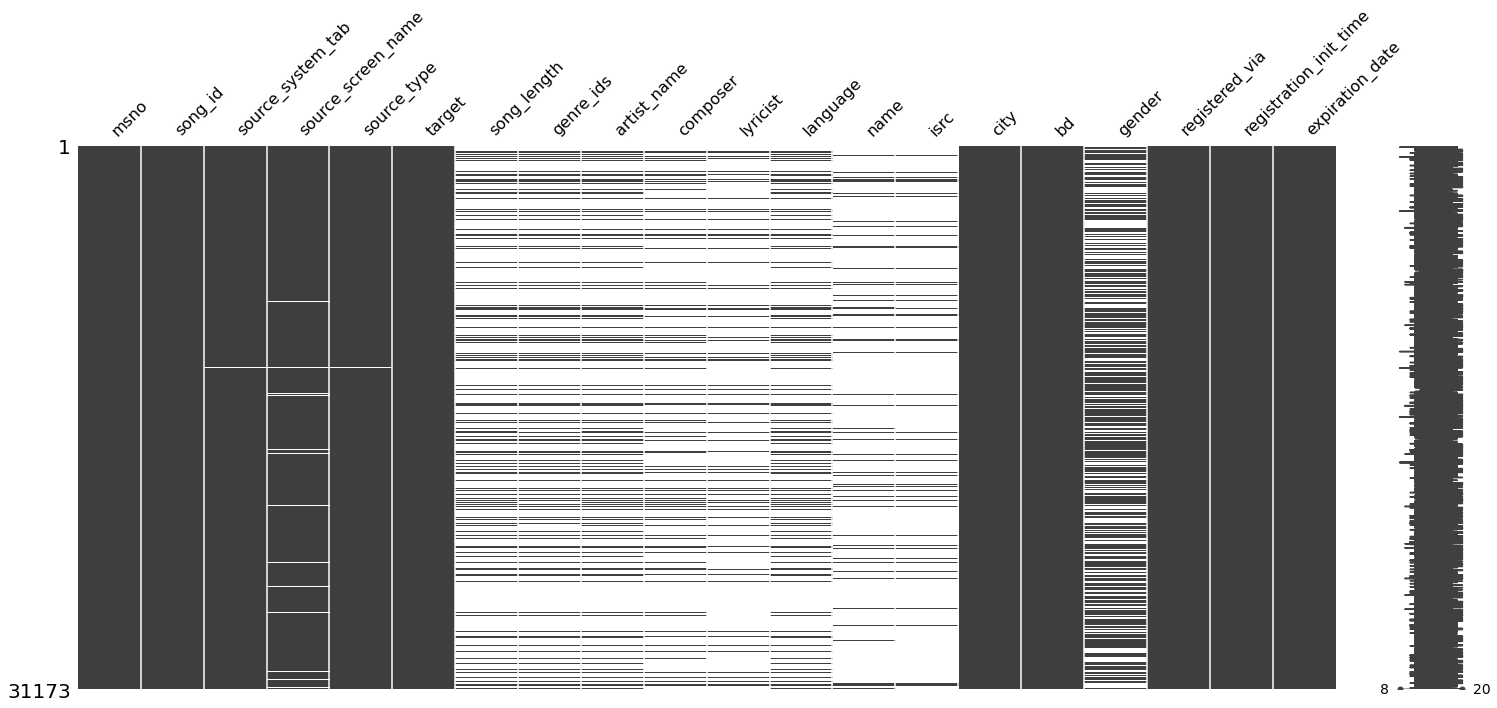

In [37]:
msno.matrix(songs)

In [38]:
for i in songs.select_dtypes(include=['object']).columns:
    songs[i][songs[i].isnull()] = 'unknown'
songs.fillna(value = 0).tail()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,city,bd,gender,registered_via,registration_init_time,expiration_date
31168,rGbXmjKDOsBV9n2LJEPtx4GcJS00c7Bs9ZFo6icxVJM=,ML4JT5C349ybpJrR9xuj9vkknukFHhaQaLpGAF8VMnw=,my library,Local playlist more,local-library,1.0,0.0,unknown,unknown,unknown,unknown,0.0,unknown,unknown,13,23,male,9,20110705,20170919
31169,eipoChVclzQ9iLORwmF3D1YvduQldX7Ms9Jgsfhz70Q=,+z1cI5V6Lw/6XhSM4kup0elEfcw08gdtP3GQbmxUubI=,my library,Local playlist more,local-library,1.0,274808.0,465,劉若英 (Rene Liu),陳小霞,施立+陳沒,3.0,unknown,unknown,15,27,male,9,20050319,20170930
31170,eipoChVclzQ9iLORwmF3D1YvduQldX7Ms9Jgsfhz70Q=,CyVtA0g6BLii1x9U65fijRIaQ3o0Y2XxpgUmzxHl9Qo=,my library,Local playlist more,local-library,1.0,228519.0,465,Various Artists,unknown,unknown,31.0,unknown,unknown,15,27,male,9,20050319,20170930
31171,d2NlxvMq+EO+xHOWa6mO1SP656/w3C4ONWLv5meA7b4=,7MOQcZUsDnFqxr0HT7oSIC3eIDdyMciaBFD9h0vvpdQ=,my library,Local playlist more,local-library,1.0,0.0,unknown,unknown,unknown,unknown,0.0,unknown,unknown,10,28,male,9,20090217,20171006
31172,d2NlxvMq+EO+xHOWa6mO1SP656/w3C4ONWLv5meA7b4=,tycgYYUG,unknown,unknown,unknown,0.0,0.0,unknown,unknown,unknown,unknown,0.0,unknown,unknown,10,28,male,9,20090217,20171006


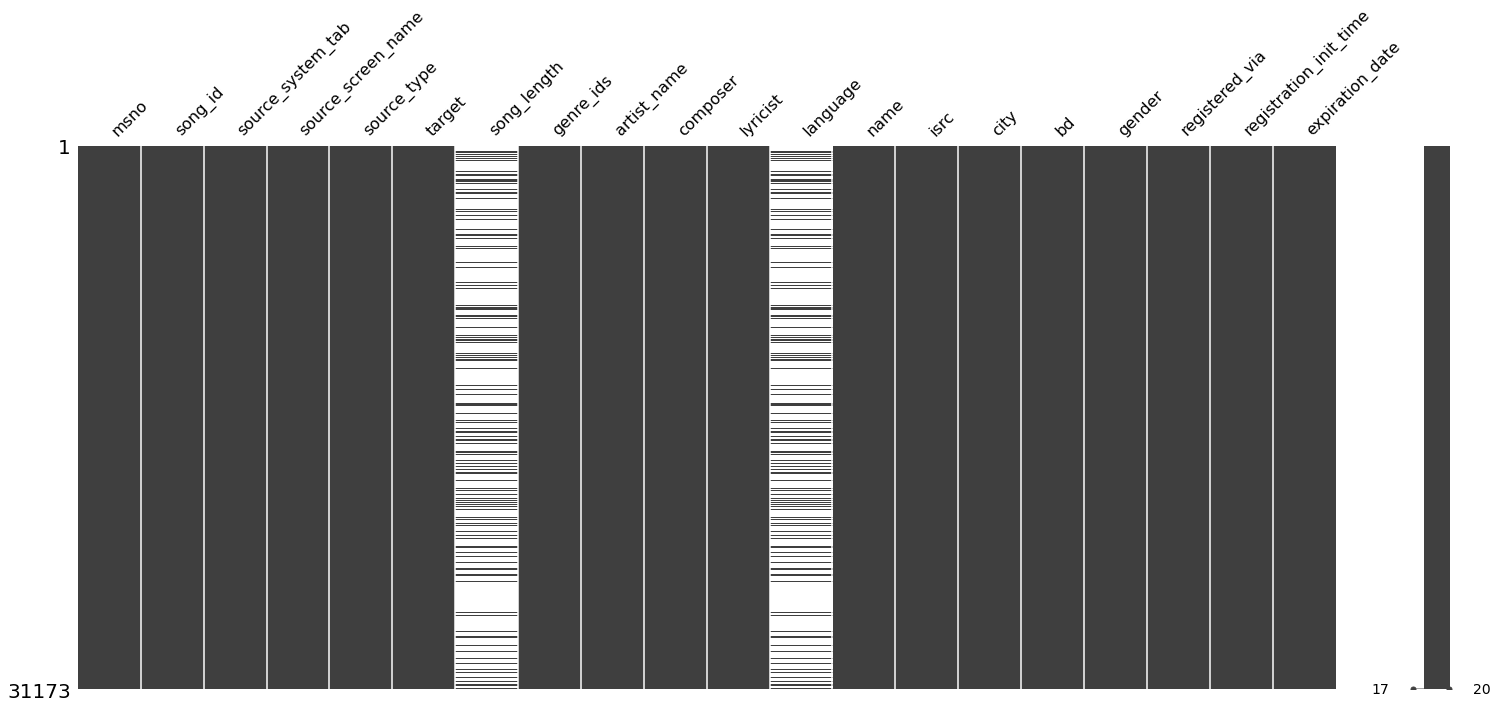

In [39]:
msno.matrix(songs)

**Extracting new Features**

In [40]:
# registration_init_time
songs.registration_init_time = pd.to_datetime(songs.registration_init_time, format='%Y%m%d', errors='ignore')
songs['registration_init_time_year'] = songs['registration_init_time'].dt.year
songs['registration_init_time_month'] = songs['registration_init_time'].dt.month
songs['registration_init_time_day'] = songs['registration_init_time'].dt.day

# expiration_date
songs.expiration_date = pd.to_datetime(songs.expiration_date,  format='%Y%m%d', errors='ignore')
songs['expiration_date_year'] = songs['expiration_date'].dt.year
songs['expiration_date_month'] = songs['expiration_date'].dt.month
songs['expiration_date_day'] = songs['expiration_date'].dt.day

In [41]:
songs.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,city,bd,gender,registered_via,registration_init_time,expiration_date,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1.0,NaN,unknown,unknown,unknown,unknown,NaN,unknown,unknown,1,0,unknown,7,2012-01-02,2017-10-05,2012,1,2,2017,10,5
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1.0,NaN,unknown,unknown,unknown,unknown,NaN,unknown,unknown,13,24,female,9,2011-05-25,2017-09-11,2011,5,25,2017,9,11
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1.0,NaN,unknown,unknown,unknown,unknown,NaN,unknown,unknown,13,24,female,9,2011-05-25,2017-09-11,2011,5,25,2017,9,11
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1.0,NaN,unknown,unknown,unknown,unknown,NaN,unknown,unknown,13,24,female,9,2011-05-25,2017-09-11,2011,5,25,2017,9,11
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1.0,NaN,unknown,unknown,unknown,unknown,NaN,unknown,unknown,1,0,unknown,7,2012-01-02,2017-10-05,2012,1,2,2017,10,5


In [42]:
label_encoder = LabelEncoder()
one_hot = OneHotEncoder()

for i in songs.columns :
    songs[i] = label_encoder.fit_transform(songs[i])

In [43]:
songs.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,city,bd,gender,registered_via,registration_init_time,expiration_date,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
0,894,2759,1,6,5,1,2238,78,682,971,441,9,676,1356,0,0,2,2,788,261,8,0,1,1,9,4
1,1860,8227,3,7,4,1,2238,78,682,971,441,9,676,1356,11,11,0,3,631,237,7,4,24,1,8,10
2,1860,4450,3,7,4,1,2238,78,682,971,441,9,676,1356,11,11,0,3,631,237,7,4,24,1,8,10
3,1860,874,3,7,4,1,2238,78,682,971,441,9,676,1356,11,11,0,3,631,237,7,4,24,1,8,10
4,894,1253,1,6,5,1,2238,78,682,971,441,9,676,1356,0,0,2,2,788,261,8,0,1,1,9,4


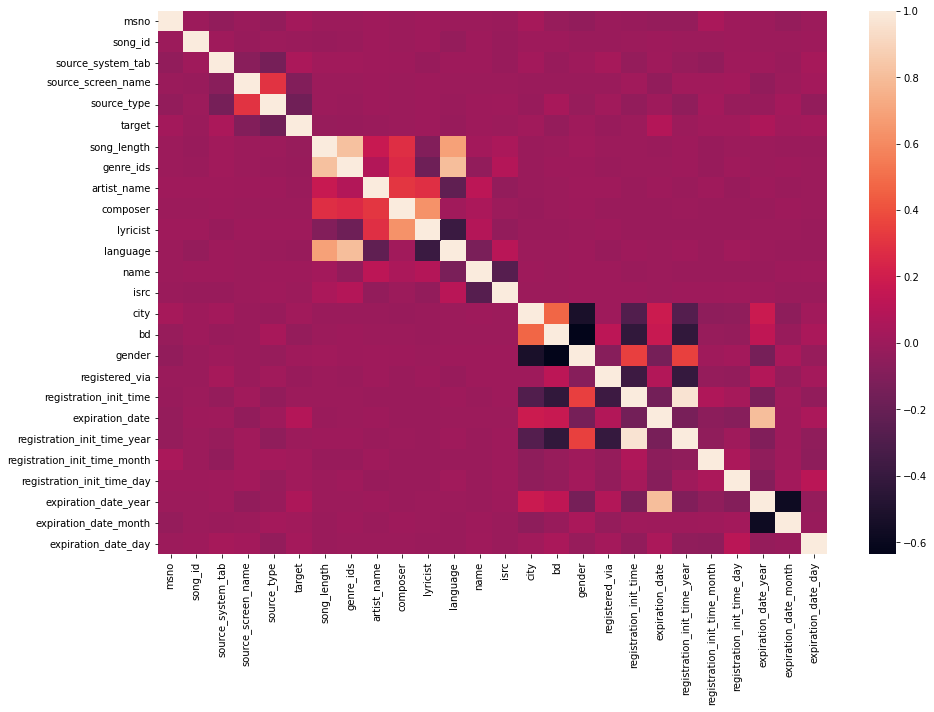

In [44]:
# Сorrelation matrix
plt.figure(figsize=[15,10])
sns.heatmap(songs.corr()) #annot = True
plt.show()

In [45]:
songs.columns

Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type', 'target', 'song_length', 'genre_ids', 'artist_name',
       'composer', 'lyricist', 'language', 'name', 'isrc', 'city', 'bd',
       'gender', 'registered_via', 'registration_init_time', 'expiration_date',
       'registration_init_time_year', 'registration_init_time_month',
       'registration_init_time_day', 'expiration_date_year',
       'expiration_date_month', 'expiration_date_day'],
      dtype='object')

In [46]:
X = songs.drop('target', axis = 1)
y = songs['target']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [55]:
def model_with(model_name, X_train, X_val, y_train, y_val) :
    print("==================================================")
    print("Modeling with :", model_name)
    print()
        
    if model_name == "Random Forest Classifier" :
        model = RandomForestClassifier(
            n_estimators=1000, 
        )
    elif model_name == "Extra Trees Classifier" :
        model = ExtraTreesClassifier(
            n_estimators=1000, 
        )
    elif model_name == "LightGBM Classifier" :
        model = lgbm.LGBMClassifier(
            n_estimators=1000, 
        )
    elif model_name == "XGBoost Classifier" :
        model = xgb.XGBClassifier(
            n_estimators=1000, 
        )
    else :
        print("Model not found in function.")
        
    model.fit(X_train, y_train)
    
    val_pred = model.predict(X_val)
    print(classification_report(y_val, val_pred))
    print()
    print("Accuracy :", accuracy_score(y_val, val_pred))
    
    print("==================================================")
    print()

In [56]:
models = ["Random Forest Classifier", "Extra Trees Classifier", "LightGBM Classifier", "XGBoost Classifier"]
for i in models :
    model_with(i, X_train, X_val, y_train, y_val)

Modeling with : Random Forest Classifier

              precision    recall  f1-score   support

           0       0.65      0.60      0.63      1851
           1       0.88      0.90      0.89      5942
           2       0.00      0.00      0.00         1

    accuracy                           0.83      7794
   macro avg       0.51      0.50      0.50      7794
weighted avg       0.82      0.83      0.83      7794


Accuracy : 0.8285860918655376

Modeling with : Extra Trees Classifier

              precision    recall  f1-score   support

           0       0.63      0.60      0.61      1851
           1       0.88      0.89      0.88      5942
           2       0.00      0.00      0.00         1

    accuracy                           0.82      7794
   macro avg       0.50      0.50      0.50      7794
weighted avg       0.82      0.82      0.82      7794


Accuracy : 0.821272773928663

Modeling with : LightGBM Classifier

              precision    recall  f1-score   support

 

**Random Forest with Class weights**

In [57]:
rf = RandomForestClassifier(
        n_estimators = 1000,
        class_weight={0: 1.0050505050505052, 1: 0.9949494949494948}
)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 1.0050505050505052,
                                     1: 0.9949494949494948},
                       n_estimators=1000)

In [58]:
val_pred = rf.predict(X_val)
print("Accuracy :", accuracy_score(y_val, val_pred))

Accuracy : 0.8283294842186297


In [59]:
# without classweights
rf = RandomForestClassifier(
        n_estimators = 1000
)
rf.fit(X_train, y_train)
val_pred = rf.predict(X_val)
print("Accuracy :", accuracy_score(y_val, val_pred))

Accuracy : 0.8287143956889915
